# Christoffel Symbols
The Christoffel symbols of the first kind are defined as
$$
\Gamma_{k|ij} = \frac{1}{2} \left( \frac{\partial g_{kj}}{\partial x^i} + \frac{\partial g_{ik}}{\partial x^j} - \frac{\partial g_{ij}}{\partial x^k} \right)
$$
Vertical bar is to divide the sym part from the other part.

Since $g_{ij}$ is sym can be stored in a vector of length 6 and similarly for the Christoffel symbols in a vector of length 18; in particular the metric is stored in a vector $g$ as
$$
g = \left( g_{00}, g_{01}, g_{02}, g_{11}, g_{12}, g_{22} \right)
$$
And the Christoffel symbols as
$$
\Gamma = \left( \Gamma_{000}, \Gamma_{001}, \Gamma_{002}, \Gamma_{011}, \Gamma_{012}, \Gamma_{022}, \Gamma_{100}, \Gamma_{101}, \Gamma_{102}, \Gamma_{111}, \Gamma_{112}, \Gamma_{122}, \Gamma_{200}, \Gamma_{201}, \Gamma_{202}, \Gamma_{211}, \Gamma_{212}, \Gamma_{222} \right)
$$
To access the component of the tensor $g_{ij}$ or $\Gamma_{k|ij}$ we use the following mapping 
$$
g_{ij} \rightarrow \begin{cases}g_{3i+j - i(i+1)/2} & i\leq j \\
i\leftrightarrow j & else \end{cases}
$$
For the Christoffel symbols we have the same mapping but with $k$ as the first index.
$$
\Gamma_{k|ij} \rightarrow \begin{cases}\Gamma_{3i+j - i(i+1)/2 + 6k} & i\leq j \\
i\leftrightarrow j & else \end{cases}

In [251]:
from ngsolve import *
from zenith import * 
from ngsolve import *
from netgen.csg import *
import scipy.sparse as sp
import matplotlib.pylab as plt



import netgen.webgui  
from ngsolve.webgui import Draw
# import netgen.gui
# %gui tk

In [252]:
def Idx(i, j,k =0):
    if i>j: i,j = j,i
    return i*3+j-(i*(i+1))//2 + k*6 

# print the indices as 3 matrices 
for i in range(3):
    for j in range(3):
        print(Idx(i,j), end=" ")
    print() 

# print the indices as 3 matrices
for i in range(3):
    for j in range(3):
        print(Idx(i,j,1), end=" ")
    print()

# print the indices as 3 matrices
for i in range(3):
    for j in range(3):
        print(Idx(i,j,2), end=" ")
    print()

0 1 2 
1 3 4 
2 4 5 
6 7 8 
7 9 10 
8 10 11 
12 13 14 
13 15 16 
14 16 17 


In [253]:
# standard mesh
with TaskManager():
    # create a mesh
    h = 0.3
    r = 0.5
    H = 0.6
    R = 1
    order = 3
    kwargs = {"bonus_intorder": 10, "inverse": "pardiso", "order": order, "mesh_order": 1}

    # BH1
    pos1 =  (0,0,0)
    lin1 = (0,0,0)
    ang1 = (0,0,0)
    mass1 =1
    BH1 = BlackHole(mass1, pos1, lin1, ang1 )

    ## BH2
    #pos2 =  (-1,0,0)
    #lin2 = (0,-1,0)
    #ang2 = (0,0,1)
    #mass2 =1
    #BH2 = BlackHole(mass2, pos2, lin2, ang2 )

    BHs = [BH1]##, BH2]

    mesh = MeshBlackHoles(BHs, h=h, R=R, H = H, r= r,  curve_order = 3)

Draw(mesh, clipping= {"z":-1})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [254]:
scl_h1 = H1(mesh, order=order)#, dirichlet="outer")
mat_h1 = VectorValued(scl_h1, 6)
tns_h1 = VectorValued(scl_h1, 18) # it is 6 x 3 

scl, dscl = scl_h1.TnT()
m, dm = mat_h1.TnT()
t, dt = tns_h1.TnT()

# define the evolution variables
gf_g  = GridFunction(mat_h1)
gf_G  = GridFunction(tns_h1)

fes = gf_g.space * gf_G.space 



# set a positive inital condition all the variables
def Peak(pnt = (0,0,0) ,**kwargs) : return exp(-kwargs.get("sigma", 1)* ( (x-pnt[0])**2 + (y-pnt[1])**2 + (z-pnt[2])**2 ) )
peak = Peak(sigma = 1)

gf_g.Set( (1+ peak,0,0,1+ peak, 0 , 1+ peak)  , bonus_intorder = 10)
Draw(gf_g , mesh, "g", clipping= {"z":-1})

gf_in = GridFunction(fes)
gf_in.components[0].vec.data = gf_g.vec

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [255]:
# use embedding to create inverse of whole matrix
inverse = "sparsecholesky"

with TaskManager():
    ## g
    mass_g = BilinearForm(mat_h1, symmetric=True)
    mass_g += InnerProduct(m, dm)*dx
    mass_g.Assemble()
    mass_g_inv = mass_g.mat.Inverse(inverse=inverse)
    res_g = fes.restrictions[0]
    inv_g = res_g.T@mass_g_inv@res_g

    ## G
    mass_G = BilinearForm(tns_h1, symmetric=True)
    mass_G += InnerProduct(t, dt)*dx
    mass_G.Assemble()
    mass_G_inv = mass_G.mat.Inverse(inverse=inverse)
    res_G = fes.restrictions[1]
    inv_G = res_G.T@mass_G_inv@res_G


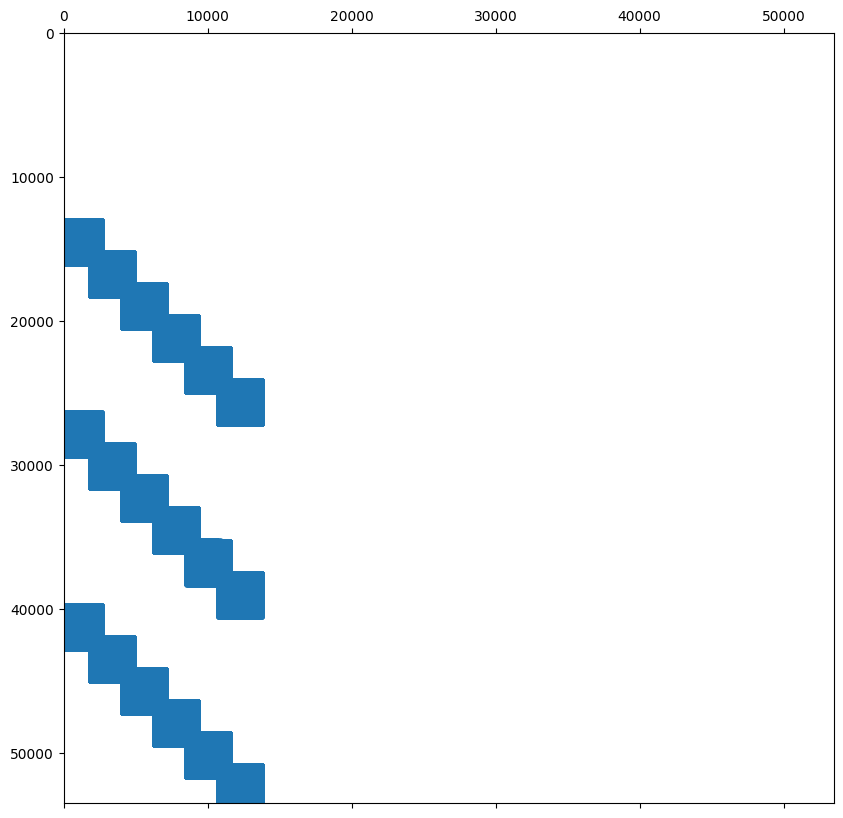

In [256]:

# trial and test functions
g,  G = fes.TrialFunction()
dg, dG = fes.TestFunction()

#dGG = dG.Reshape((6,3))
chris1 = CF( (  dG[0+6*0] , dG[1+6*0], dG[2+6*0], 
                dG[1+6*0] , dG[3+6*0], dG[4+6*0], 
                dG[2+6*0], dG[4+6*0], dG[5+6*0] ,
                dG[0+6*1] , dG[1+6*1], dG[2+6*1],
                dG[1+6*1] , dG[3+6*1], dG[4+6*1],
                dG[2+6*1], dG[4+6*1], dG[5+6*1] ,
                dG[0+6*2] , dG[1+6*2], dG[2+6*2],
                dG[1+6*2] , dG[3+6*2], dG[4+6*2],
                dG[2+6*2], dG[4+6*2], dG[5+6*2]
              ), dims=(3,3,3) )
              
blf = BilinearForm(fes)
gradg = grad(g)
for k in [0,1,2]:
    for j in [0,1,2]:
        for i in [0,1,2]:
            blf += 0.5*(InnerProduct(gradg[Idx(k,j),i] + gradg[Idx(k,i),j] -gradg[Idx(i,j),k],dG[Idx(k,j,i)]) )*dx
blf.Assemble()

A = sp.csr_matrix(blf.mat.CSR())
plt.rcParams['figure.figsize'] = (10,10)
plt.spy(A)
plt.show()

In [257]:
# # trial and test functions
# g,  G = fes.TrialFunction()
# dg, dG = fes.TestFunction()
# 
# 
# gradg = grad(g)
# blf2 = BilinearForm(fes)
# for k in [0,1,2]:
#     for i in [0,1,2]:
#         for j in [0,1,2]:
#             blf2 += 0.5*(InnerProduct(gradg[Idx(k,j),i],chris1[i,j,k]) + InnerProduct(gradg[Idx(k,i),j],chris1[i,j,k]) - InnerProduct(gradg[Idx(i,j),k],chris1[i,j,k]))*dx
#             blf2 +=  -0.5*(InnerProduct(gradg[Idx(k,j),i] + gradg[Idx(k,i),j] -gradg[Idx(i,j),k],dG[Idx(k,j,i)]) )*dx
# blf2.Assemble()
# 
# A = sp.csr_matrix(blf2.mat.CSR()  )
# plt.rcParams['figure.figsize'] = (10,10)
# plt.spy(A)
# plt.show()

In [258]:
inv_mass = inv_g +  inv_G 


In [270]:
gf_out = GridFunction(fes)

with TaskManager():
        
    gf_out.vec.data = inv_mass @ blf.mat *gf_in.vec



    


In [271]:
Draw(gf_out.components[1], mesh, "Gamma_out",  clipping= {"z":-1})



WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [272]:
True_g = CF((1+ peak,0,0,0,1+ peak, 0,0,0 , 1+ peak), dims=(3,3) )
True_inv_g = CF((1/(1+ peak),0,0,0,1/(1+ peak), 0,0,0 , 1/(1+ peak)), dims=(3,3) )  
True_grad_g = CF((True_g.Diff(x), True_g.Diff(y), True_g.Diff(z)), dims=(3,3,3) )
True_Gamma = 0.5*(fem.Einsum("ijk->ikj", True_grad_g) + fem.Einsum("ijk->jki", True_grad_g) - fem.Einsum("ijk->ijk", True_grad_g))
True_Gamma2 = fem.Einsum("ijl,lk->ijk",True_Gamma,True_inv_g)

Draw(Norm(True_Gamma2), mesh, "Gamma_true",  clipping= {"z":-1})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [273]:

#Draw(gf_out.components[1][] , mesh, "Gamma_comp",  clipping= {"z":-1})

In [274]:
i = 0
j = 0
k = 0

Draw(gf_out.components[1][Idx(i,j,k)], mesh, "Gamma" ,  clipping= {"z":-1})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [275]:
Draw(True_Gamma[i,j,k], mesh, "Gamma" ,  clipping= {"z":-1})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [276]:
Draw(True_Gamma[i,j,k]-gf_out.components[1][Idx(i,j,k)], mesh, "Gamma" ,  clipping= {"z":-1})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [277]:
tot =0.0
for k in [0,1,2]:
    for i in [0,1,2]:
        for j in [0,1,2]:
            tot += Integrate( Norm(True_Gamma[i,j,k]-gf_out.components[1][Idx(i,j,k)]) , mesh)



In [278]:
print(tot)

0.06892530724401658


In [279]:
E000 = True_Gamma[0,0,0]-gf_out.components[1][Idx(0,0,0)]
print(Integrate( Norm(E000) , mesh))
E001 = True_Gamma[0,0,1]-gf_out.components[1][Idx(0,0,1)]
print(Integrate( Norm(E001) , mesh))
E002 = True_Gamma[0,0,2]-gf_out.components[1][Idx(0,0,2)]
print(Integrate( Norm(E002) , mesh))
E010 = True_Gamma[0,1,0]-gf_out.components[1][Idx(0,1,0)]
print(Integrate( Norm(E010) , mesh))
E011 = True_Gamma[0,1,1]-gf_out.components[1][Idx(0,1,1)]
print(Integrate( Norm(E011) , mesh))
E012 = True_Gamma[0,1,2]-gf_out.components[1][Idx(0,1,2)]
print(Integrate( Norm(E012) , mesh))
E020 = True_Gamma[0,2,0]-gf_out.components[1][Idx(0,2,0)]
print(Integrate( Norm(E020) , mesh))
E021 = True_Gamma[0,2,1]-gf_out.components[1][Idx(0,2,1)]
print(Integrate( Norm(E021) , mesh))
E022 = True_Gamma[0,2,2]-gf_out.components[1][Idx(0,2,2)]
print(Integrate( Norm(E022) , mesh))
E100 = True_Gamma[1,0,0]-gf_out.components[1][Idx(1,0,0)]
print(Integrate( Norm(E100) , mesh))
E101 = True_Gamma[1,0,1]-gf_out.components[1][Idx(1,0,1)]
print(Integrate( Norm(E101) , mesh))
E102 = True_Gamma[1,0,2]-gf_out.components[1][Idx(1,0,2)]
print(Integrate( Norm(E102) , mesh))
E110 = True_Gamma[1,1,0]-gf_out.components[1][Idx(1,1,0)]
print(Integrate( Norm(E110) , mesh))
E111 = True_Gamma[1,1,1]-gf_out.components[1][Idx(1,1,1)]
print(Integrate( Norm(E111) , mesh))
E112 = True_Gamma[1,1,2]-gf_out.components[1][Idx(1,1,2)]
print(Integrate( Norm(E112) , mesh))
E120 = True_Gamma[1,2,0]-gf_out.components[1][Idx(1,2,0)]
print(Integrate( Norm(E120) , mesh))
E121 = True_Gamma[1,2,1]-gf_out.components[1][Idx(1,2,1)]
print(Integrate( Norm(E121) , mesh))
E122 = True_Gamma[1,2,2]-gf_out.components[1][Idx(1,2,2)]
print(Integrate( Norm(E122) , mesh))
E200 = True_Gamma[2,0,0]-gf_out.components[1][Idx(2,0,0)]
print(Integrate( Norm(E200) , mesh))
E201 = True_Gamma[2,0,1]-gf_out.components[1][Idx(2,0,1)]
print(Integrate( Norm(E201) , mesh))
E202 = True_Gamma[2,0,2]-gf_out.components[1][Idx(2,0,2)]
print(Integrate( Norm(E202) , mesh))
E210 = True_Gamma[2,1,0]-gf_out.components[1][Idx(2,1,0)]
print(Integrate( Norm(E210) , mesh))
E211 = True_Gamma[2,1,1]-gf_out.components[1][Idx(2,1,1)]
print(Integrate( Norm(E211) , mesh))
E212 = True_Gamma[2,1,2]-gf_out.components[1][Idx(2,1,2)]
print(Integrate( Norm(E212) , mesh))
E220 = True_Gamma[2,2,0]-gf_out.components[1][Idx(2,2,0)]
print(Integrate( Norm(E220) , mesh))
E221 = True_Gamma[2,2,1]-gf_out.components[1][Idx(2,2,1)]
print(Integrate( Norm(E221) , mesh))
E222 = True_Gamma[2,2,2]-gf_out.components[1][Idx(2,2,2)]
print(Integrate( Norm(E222) , mesh))

Error = CF((E000,E001,E002,E010,E011,E012,E020,E021,E022,E100,E101,E102,E110,E111,E112,E120,E121,E122,E200,E201,E202,E210,E211,E212,E220,E221,E222), dims=(3,3,3) )

0.007309701315750799
0.007222407767814947
0.008442993331106442
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0073097013157508006
0.007222407767814949
0.008442993331106445
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0073097013157507945
0.007222407767814954
0.008442993331106449


0.047703798196440154
0.04953052424708752
0.05312731079723029

In [284]:
Draw(E000, mesh, "Error" ,  clipping= {"z":-1})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene